# QKeras RNN comparison


1. Create a model and compare its performance to the boosted model
2. If the model outreach the performance of the boosted model : 
 -   create a model with the same feature with qkeras (QAT) and 
 -   quantized the keras model (PTQ)
3. Compare those two to PTQ boosted model

The models with keras should converge to around 1e-5 or 9.8e-6

For QKeras it's been somewhere around 1.1e-5 or so



# To Run Everytime

## Imports

In [16]:
import tensorflow as tf
import keras
import numpy as np
import time
import random
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Activation, Flatten, LSTM, GRU, SimpleRNN, Conv2D, MaxPooling2D, Flatten, Dropout, Reshape
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

from collections import deque


from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from matplotlib import pyplot as plt
from IPython.display import clear_output

import qkeras
from qkeras import *

import hls4ml
import nnlar
from nnlar.datashaper import DataShaper

In [17]:
# Load libraries if they are changed
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Data creation 

In [18]:
from nnlar.datashaper import DataShaper
ds = DataShaper.from_h5("../data/rdgap_mu140.h5")

x, x_val, x_test, y, y_val, y_test = ds()

shapes (1999995, 5, 1) (1999995, 1)
shapes (899992, 5, 1) (99995, 5, 1) (999998, 5, 1)


In [19]:
boosted_model =  tf.keras.models.load_model('pb_file')

boosted_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 8)                 80        
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


## Settings

In [20]:
# settings of the networks 
output = 1

nbr_batch = 32
nbr_epoch = 500
lr=0.0001

nbr_conv_epoch = 4 #number of epochs for the conversion 


def units(j): 
   return (j+2)*2

units_range = 5

In [21]:
#quantized settings
integer = 0

def bit_lenghts(i):
    #To change to create models with different bits parameter by defining the smallest bit lenghts 
    #Example : bits 8 ==> (i+4)*4
    return (i+2)*2

def bit_width(i): return {'bits': (i+2)*2, 'integer': integer, 'symmetric': 0, 'alpha':1}

bits_range = 5

In [22]:
# path

#path of the tested models 
def models_path(j) : return f"tests/models_test/epochs={nbr_epoch}/models_units={units(j)}_batch={nbr_batch}_lr={lr}.h5"

#path of the qconverted models
def qmodels_path(j, i): return f"tests/qmodels_test/qconverted/qmodels_units={units(j)}_epoch={nbr_conv_epoch}_batch={nbr_batch}_lr={lr},<{bit_lenghts(i)},{integer}>.h5"

#path of the qtrained models
def qtrained_models_path(j, i): return f"tests/qmodels_test/qtrained/qmodels_units={units(j)}_epoch={nbr_epoch}_batch={nbr_batch}_lr={lr},<{bit_lenghts(i)},{integer}>.h5"

#path of the qref models 
def qrefmodels_path (i) : return f"qmodels_epoch={nbr_conv_epoch}/qmodels<{bit_lenghts(i)},{integer}>.h5"

# 1. Creating a good network

## Training of the classic model

In [15]:
def normal_model (units_parameter):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=10, 
                                                    restore_best_weights=True, 
                                                    min_delta=0.000001,
                                                    mode='min')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience=5, min_lr=0.000001, verbose=1)

    r_model = Sequential()
    r_model.add(SimpleRNN(units_parameter, input_shape=(5, 1), return_sequences=False, name='SimpleRNN'))
    r_model.add(Dense(output, activation='relu',name='dense'))
    r_model.compile(loss="mean_squared_error", optimizer=Adam(lr=0.001))


    r_model.summary()

    r_model.fit(x,y,validation_data=(x_val,y_val), epochs=nbr_epoch, batch_size=40, shuffle=True, callbacks=[early_stopping, reduce_lr])


    return r_model

def model_training (): 
    models =[]

    for j in range(units_range):
        if (os.path.exists(models_path(j))==False):
            model = normal_model(units_parameter)
            models.append(model)
            model.save(models_path(j))
            print('number of units ', units_parameter)  
        else : print(f'{models_path(j)} already exists')        
    return models

models = model_training()

NameError: name 'units_parameter' is not defined

## Comparison with the reference model

31250/31250 [==============================] - 42s 1ms/step
mseref-msemodel =  -3.877312e-05


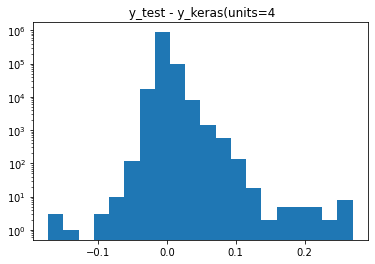

31250/31250 [==============================] - 39s 1ms/step
mseref-msemodel =  -4.109556e-05


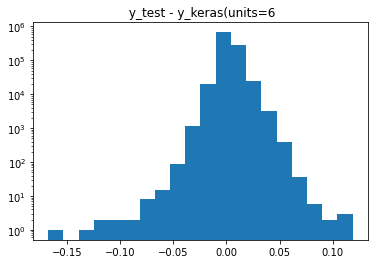

31250/31250 [==============================] - 41s 1ms/step
mseref-msemodel =  -1.0651163e-05


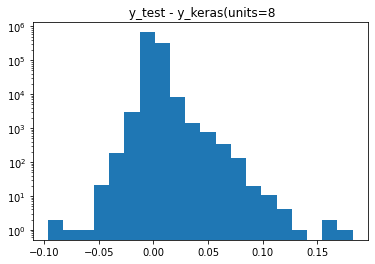

31250/31250 [==============================] - 42s 1ms/step
mseref-msemodel =  -1.4266101e-05


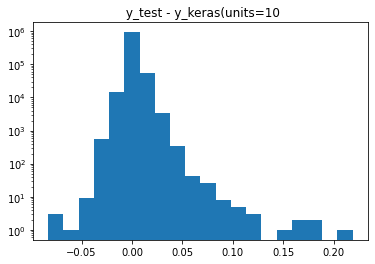

31250/31250 [==============================] - 39s 1ms/step
mseref-msemodel =  -3.3466145e-05


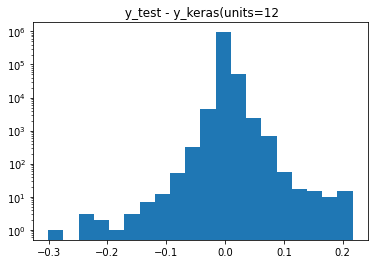

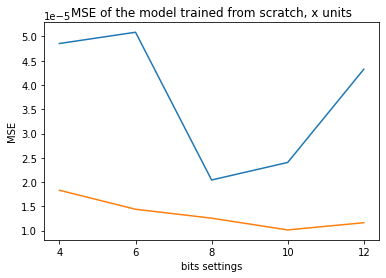

In [ ]:
y_ref = boosted_model.predict(x_test)
loss1 = [] 
loss2 = [] #contain the losses of the models with different units number
diff_loss = []  

bit_nbr = []

for i in range(bits_range):
    model = qkeras.utils.load_qmodel(qtrained_models_path(0,i))
    model1 = qkeras.utils.load_qmodel(qtrained_models_path(1,i))
    bit_nbr.append(bit_lenghts(i))

    y_keras = model.predict(x_test)
    y_keras2 = model1.predict(x_test)

    diff = mse(y_test, y_ref)-mse(y_test,y_keras)
    print('mseref-msemodel = ',diff)
    
    diff_loss.append(diff)
    loss1.append(mse(y_test,y_keras))
    loss2.append(mse(y_test,y_keras2))
    

    plt.figure()
    plt.hist(y_test-y_keras, bins=20)
    plt.yscale('log')
    plt.title(f' y_test - y_keras(units={bit_lenghts(i)}')
    plt.show()
    
plt.figure()
plt.plot(loss1)
plt.plot(loss2)
plt.xticks(np.arange(len(bit_nbr)), [f"{unit}" for unit in bit_nbr])
plt.xlabel('bits settings')
plt.ylabel('MSE')
plt.title(f'MSE of the model trained from scratch, x units')
plt.show()

In [ ]:
plt.figure()
plt.plot(loss1)
plt.plot(loss2)
plt.xticks(np.arange(len(bit_nbr)), [f"{unit}" for unit in bit_nbr])
plt.xlabel('bits settings')
plt.ylabel('MSE')
plt.title(f'MSE of the model trained from scratch, x units')
plt.show()

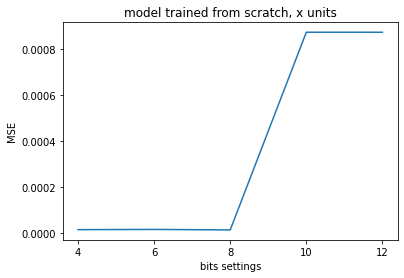

[-4.718733e-06, -5.689386e-06, -3.5908497e-06, -0.0008628192, -0.0008628192]


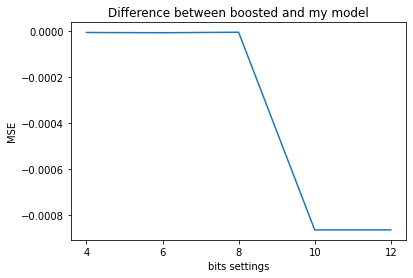

In [ ]:
plt.figure()
plt.plot(loss1)
plt.xticks(np.arange(len(unit_nbr)), [f"{unit}" for unit in unit_nbr])
plt.xlabel('bits settings')
plt.ylabel('MSE')
plt.title(f'model trained from scratch, x units')
plt.show()

plt.figure()
plt.plot(diff_loss)
plt.xticks(np.arange(len(unit_nbr)), [f"{unit}" for unit in unit_nbr])
plt.xlabel('bits settings')
plt.ylabel('MSE')
plt.title(f'Difference between boosted and my model')
print (diff_loss)
plt.show()

# 2. Quantizing it 

## Quantization conversion

In [10]:
def quantized_conv_model (bits, units_parameter, model_to_convert):  

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=10, 
                                                    restore_best_weights=True, 
                                                    min_delta=0.000001,
                                                    mode='min')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience=5, min_lr=0.000001, verbose=1)  
    qr_model = Sequential()

    qr_model.add(QSimpleRNN(units_parameter,
                        input_dim= 1,
                        activation='relu',
                        kernel_quantizer=quantized_bits(**bits),
                        recurrent_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits)    
                        ))
       
    qr_model.add(QDense(output, 
                        activation='linear',
                        kernel_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits) ))

    qr_model.compile(loss="mse", optimizer=Adam(lr))
    
    qr_model.summary()
    #using the weight from the classic network as a base
    qr_model.set_weights(model_to_convert.get_weights())
    qr_model.fit(x, y, validation_data= (x_val,y_val),epochs = nbr_conv_epoch, batch_size=40, shuffle=True, callbacks=[early_stopping, reduce_lr])

    return qr_model

def qmodel_conv_training (): 

    qmodels =[]
    for i in range(bits_range):
        bits_parameter = bit_width(i)
        for j in range(units_range):
            if (os.path.exists(qmodels_path(j,i))==False):
                qmodel = quantized_conv_model(bits_parameter, units(j), tf.keras.models.load_model(models_path(j)))
                qmodel.save(qmodels_path(j,i))
                qmodels.append(qmodel)
            else : print(f'{qmodels_path(j,i)} already exists')
        print( 'bit width ', bits_parameter)        
    return qmodels
        
qmodels = qmodel_conv_training()

tests/qmodels_test/qconverted/qmodels_units=4_epoch=4_batch=40_lr=0.001,<4,0>.h5 already exists
tests/qmodels_test/qconverted/qmodels_units=6_epoch=4_batch=40_lr=0.001,<4,0>.h5 already exists
tests/qmodels_test/qconverted/qmodels_units=8_epoch=4_batch=40_lr=0.001,<4,0>.h5 already exists
tests/qmodels_test/qconverted/qmodels_units=10_epoch=4_batch=40_lr=0.001,<4,0>.h5 already exists
tests/qmodels_test/qconverted/qmodels_units=12_epoch=4_batch=40_lr=0.001,<4,0>.h5 already exists
bit width  {'bits': 4, 'integer': 0, 'symmetric': 0, 'alpha': 1}
tests/qmodels_test/qconverted/qmodels_units=4_epoch=4_batch=40_lr=0.001,<6,0>.h5 already exists
tests/qmodels_test/qconverted/qmodels_units=6_epoch=4_batch=40_lr=0.001,<6,0>.h5 already exists
tests/qmodels_test/qconverted/qmodels_units=8_epoch=4_batch=40_lr=0.001,<6,0>.h5 already exists
tests/qmodels_test/qconverted/qmodels_units=10_epoch=4_batch=40_lr=0.001,<6,0>.h5 already exists
tests/qmodels_test/qconverted/qmodels_units=12_epoch=4_batch=40_lr=0

31250/31250 [==============================] - 33s 1ms/step


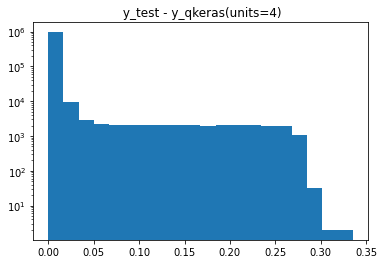

31250/31250 [==============================] - 35s 1ms/step


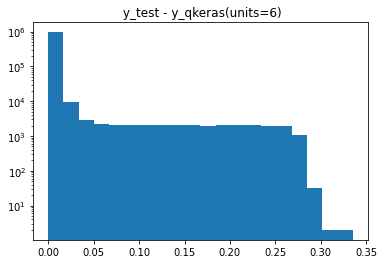

31250/31250 [==============================] - 35s 1ms/step


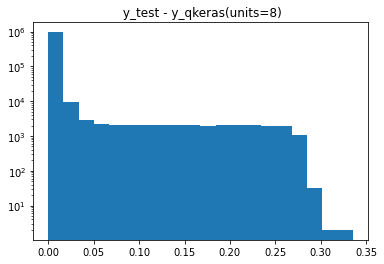

31250/31250 [==============================] - 34s 1ms/step


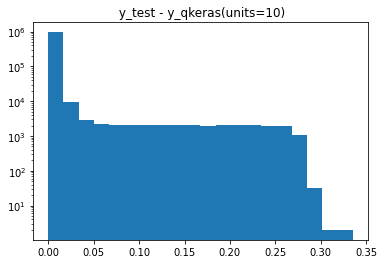

31250/31250 [==============================] - 35s 1ms/step


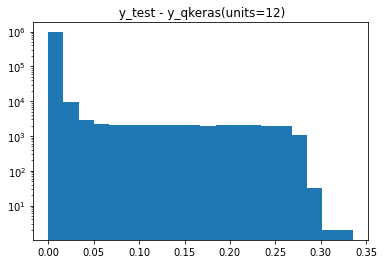

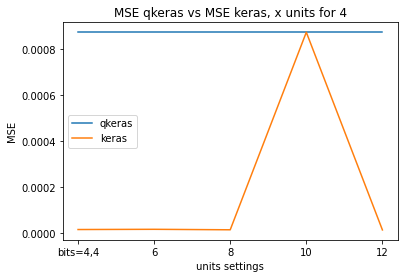

31250/31250 [==============================] - 33s 1ms/step


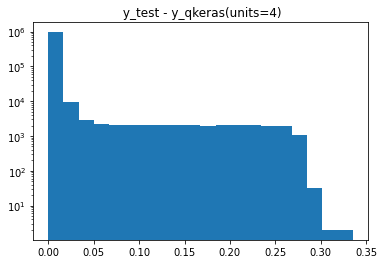

31250/31250 [==============================] - 35s 1ms/step


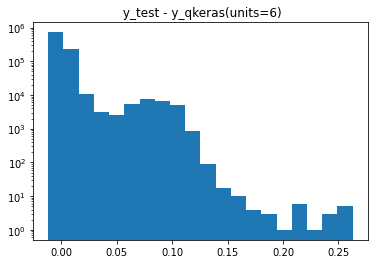

31250/31250 [==============================] - 35s 1ms/step


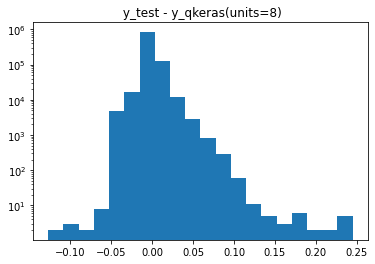

31250/31250 [==============================] - 33s 1ms/step


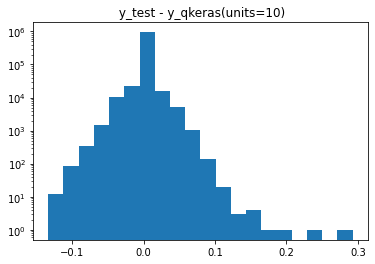

31250/31250 [==============================] - 35s 1ms/step


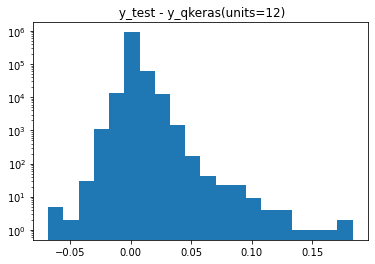

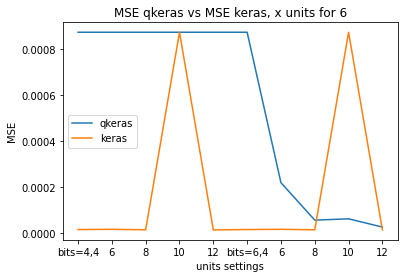

31250/31250 [==============================] - 34s 1ms/step


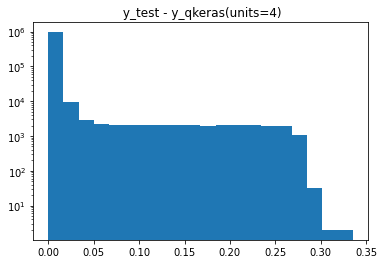

31250/31250 [==============================] - 34s 1ms/step


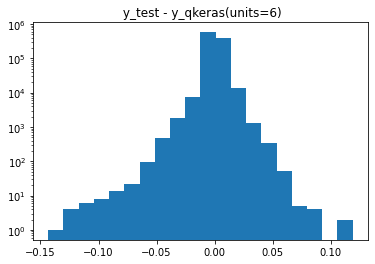

31250/31250 [==============================] - 35s 1ms/step


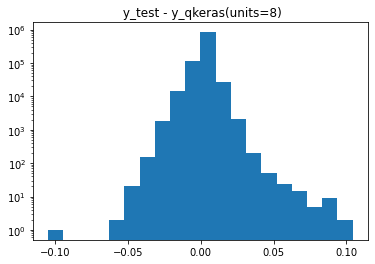

31250/31250 [==============================] - 35s 1ms/step


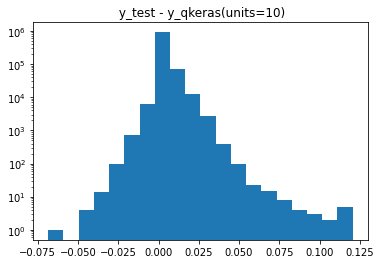

31250/31250 [==============================] - 34s 1ms/step


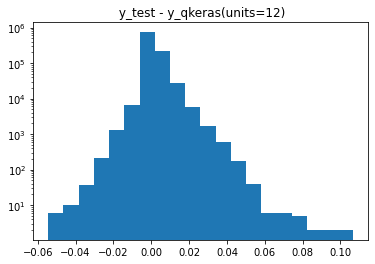

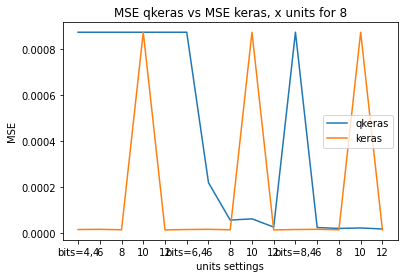

31250/31250 [==============================] - 32s 1ms/step


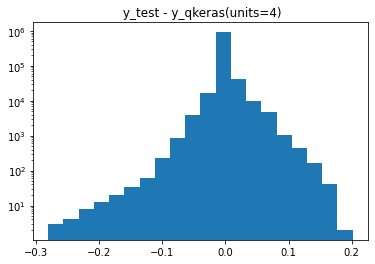

31250/31250 [==============================] - 33s 1ms/step


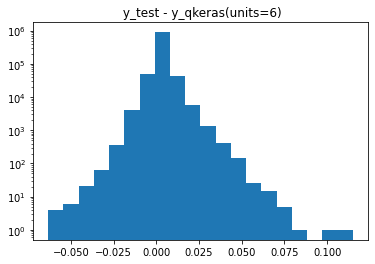

31250/31250 [==============================] - 34s 1ms/step


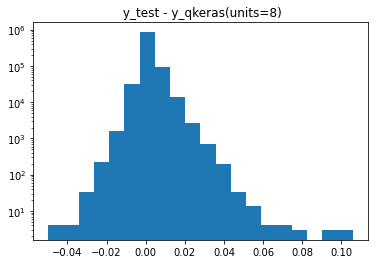

31250/31250 [==============================] - 33s 1ms/step


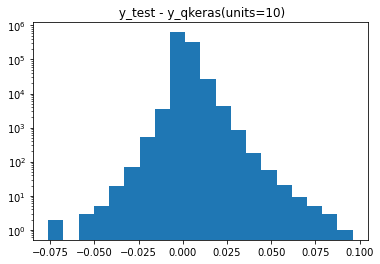

31250/31250 [==============================] - 35s 1ms/step


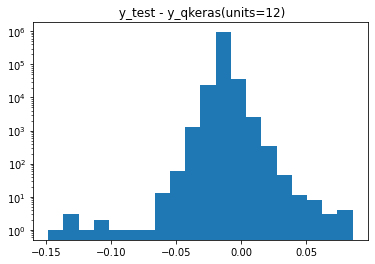

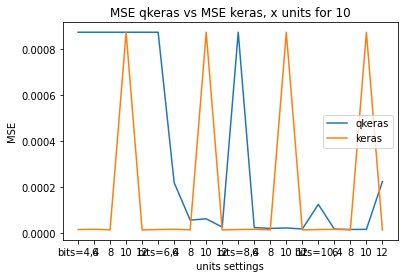

31250/31250 [==============================] - 36s 1ms/step


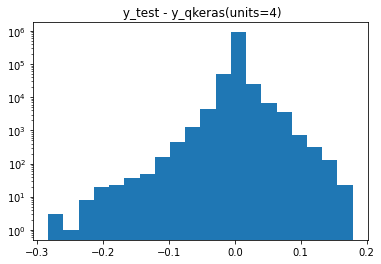

31250/31250 [==============================] - 36s 1ms/step


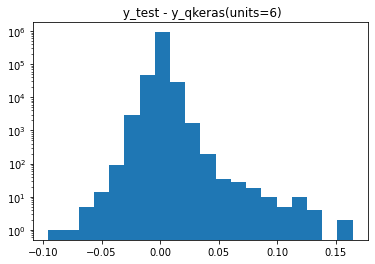

31250/31250 [==============================] - 35s 1ms/step


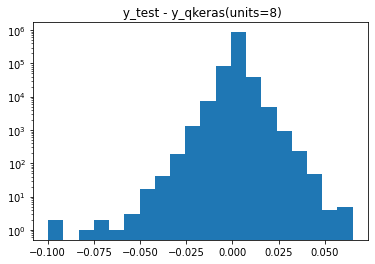

31250/31250 [==============================] - 34s 1ms/step


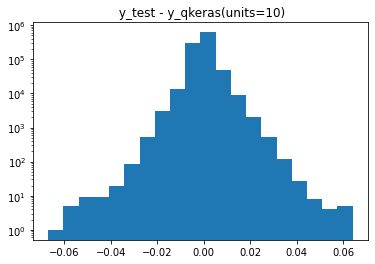

31250/31250 [==============================] - 35s 1ms/step


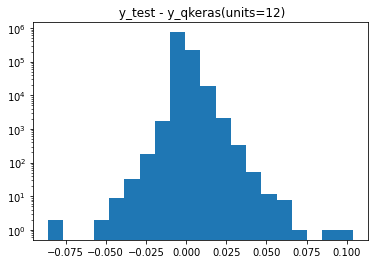

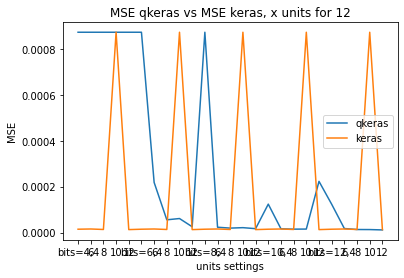

In [8]:

bit_nbr = []
loss1 = [] 
loss2 = []
unit_nbr = []

for i in range(bits_range):

    bit_nbr.append(bit_lenghts(i))
    for j in range (units_range):
        if (j==0):
            unit_nbr.append(f'bits={bit_lenghts(i)},{units(j)}')
        else: 
            unit_nbr.append(f'{units(j)}')
        qmodel = qkeras.utils.load_qmodel(qmodels_path(j,i))        
        y_qkeras = qmodel.predict(x_test)
        model = tf.keras.models.load_model(models_path(j))
        y_keras = model.predict(x_test)

        loss1.append(mse(y_test,y_qkeras))        
        loss2.append(mse(y_test,y_keras))

        plt.figure()
        plt.hist(y_test-y_qkeras, bins=20)
        plt.yscale('log')
        plt.title(f' y_test - y_qkeras(units={units(j)})')
        plt.show()
        
    plt.figure()
    plt.plot(loss1)
    plt.plot(loss2)
    plt.legend(['qkeras','keras'])
    plt.xticks(np.arange(len(unit_nbr)), [f"{unit}" for unit in unit_nbr])
    plt.xlabel('units settings')
    plt.ylabel('MSE')
    plt.title(f'MSE qkeras vs MSE keras, x units for {bit_lenghts(i)}')
    plt.show()

## Quantization training 

In [23]:
def quantized_model (bits, units_parameter,):  

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                    patience=10, 
                                                    restore_best_weights=True, 
                                                    min_delta=0.000001,
                                                    mode='min')

    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                patience=5, min_lr=0.000001, verbose=1)  
    qr_model = Sequential()

    qr_model.add(QSimpleRNN(units_parameter,
                        input_dim= 1,
                        activation='relu',
                        kernel_quantizer=quantized_bits(**bits),
                        recurrent_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits)    
                        ))
       
    qr_model.add(QDense(output, 
                        activation='linear',
                        kernel_quantizer=quantized_bits(**bits),
                        bias_quantizer=quantized_bits(**bits) ))

    qr_model.compile(loss="mse", optimizer=Adam(lr))
    
    qr_model.summary()

    qr_model.fit(x, y, validation_data= (x_val,y_val), epochs = nbr_epoch, batch_size= nbr_batch, shuffle=True, callbacks=[early_stopping, reduce_lr])

    return qr_model

def qmodel_training (): 

    qmodels =[]
    for i in range(bits_range):
        bits_parameter = bit_width(i)
        for j in range(units_range):
            if (os.path.exists(qtrained_models_path(j,i))==False):
                units_parameter = units(j)
                qmodel = quantized_model(bits_parameter, units_parameter)
                qmodel.save(qtrained_models_path(j,i))
                qmodels.append(qmodel)
            else : print(f'{qtrained_models_path(j,i)} already exists')
        print( 'bit width ', bits_parameter)        
    return qmodels
        
qmodels = qmodel_training()
        

tests/qmodels_test/qtrained/qmodels_units=4_epoch=500_batch=32_lr=0.0001,<4,0>.h5 already exists
tests/qmodels_test/qtrained/qmodels_units=6_epoch=500_batch=32_lr=0.0001,<4,0>.h5 already exists
tests/qmodels_test/qtrained/qmodels_units=8_epoch=500_batch=32_lr=0.0001,<4,0>.h5 already exists
tests/qmodels_test/qtrained/qmodels_units=10_epoch=500_batch=32_lr=0.0001,<4,0>.h5 already exists
tests/qmodels_test/qtrained/qmodels_units=12_epoch=500_batch=32_lr=0.0001,<4,0>.h5 already exists
bit width  {'bits': 4, 'integer': 0, 'symmetric': 0, 'alpha': 1}
tests/qmodels_test/qtrained/qmodels_units=4_epoch=500_batch=32_lr=0.0001,<6,0>.h5 already exists
tests/qmodels_test/qtrained/qmodels_units=6_epoch=500_batch=32_lr=0.0001,<6,0>.h5 already exists
tests/qmodels_test/qtrained/qmodels_units=8_epoch=500_batch=32_lr=0.0001,<6,0>.h5 already exists
tests/qmodels_test/qtrained/qmodels_units=10_epoch=500_batch=32_lr=0.0001,<6,0>.h5 already exists
tests/qmodels_test/qtrained/qmodels_units=12_epoch=500_batc

# 3. Compare the results

In [ ]:
loss1 = []
loss2 = []
loss3 = []
bits_nbr = [] 

for i in range(bits_range):
    
    model = qkeras.utils.load_qmodel(qmodels_path(0,i))
    model_ref = qkeras.utils.load_qmodel(f"qmodels_test/qmodels_units={units(0)},<{bit_lenghts(i)},{integer}>.h5")
    bits_nbr.append(bit_lenghts(i))
    y_keras = model.predict(x_test)
    y_qref = model_ref.predict(x_test)
    loss1.append(mse(y_test,y_ref))
    loss2.append(mse(y_test,y_qref))
    loss3.append(mse(y_test,y_keras))

    print ('lossref-loss', (mse(y_test,y_qref)-mse(y_test,y_keras)))
    plt.figure()
    plt.hist(y_test-y_keras, bins=20)
    plt.yscale('log')
    plt.title(f' y_test - y_keras(bits={bit_lenghts(i)}')
    plt.show()

plt.figure()
plt.plot(loss1)
plt.plot(loss2)
plt.plot(loss3)
plt.legend(['ref','qref','qmodel'])
plt.xticks(np.arange(len(bits_nbr)), [f"{bits}" for bits in bits_nbr])
plt.xlabel('bits settings')
plt.ylabel('MSE')
plt.title(f'model trained from scratch, x units')
plt.show()

TypeError: qmodels_path() takes 1 positional argument but 2 were given